# Baseline

## Общая инициализация
Нужно выполнить в самом начале независимо от дальнейших действий

### Путь к каталогу, в котором лежит датасет
датасет представлен файлом `train.csv` и папкой `train`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_folder = "/content/drive/MyDrive/event_detection_kaggle"

### Импорты

In [ ]:
import os
import os.path as path
import pickle
import random

import pandas as pd
import numpy as np
from enum import Enum
from typing import NoReturn, Optional
from pprint import pprint

from concurrent.futures import ThreadPoolExecutor, as_completed

import matplotlib.pyplot as plt
from IPython.display import Audio

import librosa
import librosa.feature as F_librosa
import librosa.display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F_torch
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, f1_score, classification_report

from tqdm import tqdm

from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, OneCycleLR, StepLR

#### Инициализация путей

In [ ]:
# path
train_folder = path.join(base_folder, "train")
train_csv = path.join(base_folder, "train.csv")
train_pickle = path.join(base_folder, "train.pickle")
labels_pickle = path.join(base_folder, "labels.pickle")
test_folder = path.join(base_folder, "test")
test_labels = "sample_submission.csv"

### Изучение аудиофайлов датасета

In [ ]:
# random filename from dir
files = os.listdir(train_folder)
filename = random.choice(files)
filename

'49347ce102c8d1e876e0.wav'

#### Спектрограмма

In [ ]:
sample_rate = 11025

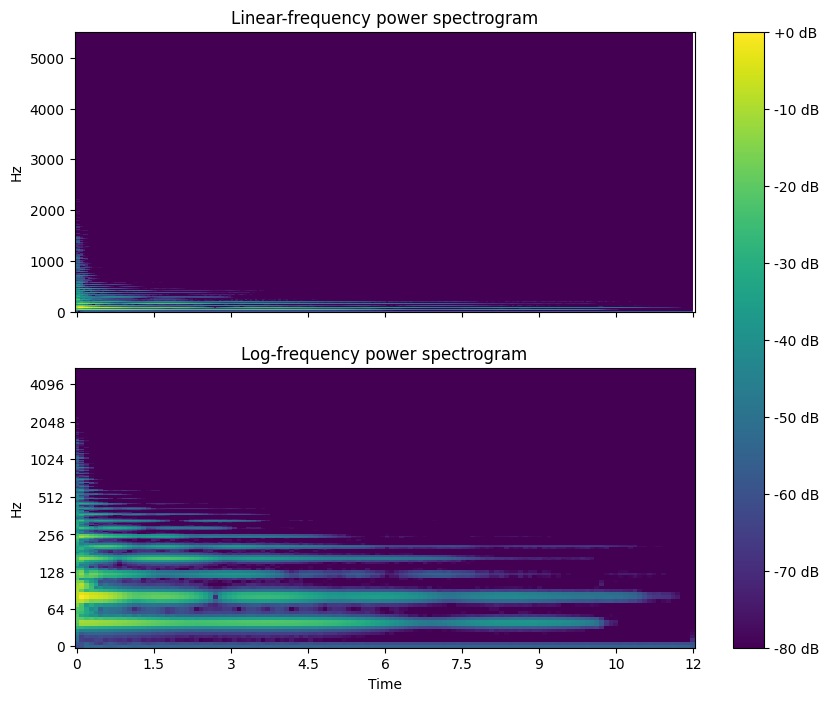

In [ ]:
wav_data, sr = librosa.load(os.path.join(train_folder, filename), sr=sample_rate)

fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
cmap = "viridis"

# draw linear-frequency spectrogram
hop_length = 512
wav_data_db = librosa.amplitude_to_db(
    np.abs(librosa.stft(wav_data, hop_length=hop_length)),
    ref=np.max
)
img1 = librosa.display.specshow(
    wav_data_db,
    sr=sr,
    hop_length=hop_length,
    ax=ax_top,
    x_axis='time',
    y_axis='linear',
    cmap=cmap,
)
ax_top.set(title='Linear-frequency power spectrogram')
ax_top.label_outer()

# draw log-frequency spectrogram
hop_length = 1024
wav_data_db = librosa.amplitude_to_db(
    np.abs(librosa.stft(wav_data, hop_length=hop_length)),
    ref=np.max
)
img2 = librosa.display.specshow(
    wav_data_db,
    sr=sr,
    hop_length=hop_length,
    ax=ax_bottom,
    x_axis='time',
    y_axis='log',
    cmap=cmap,
)
ax_bottom.set(title='Log-frequency power spectrogram')
ax_bottom.label_outer()

fig.colorbar(img1, ax=[ax_top, ax_bottom], format="%+2.f dB")
plt.show()

display(Audio(wav_data, rate=sr))

#### Mel-спектрограмма

In [ ]:
# melspectrogram parameters
sample_rate = 11025
n_fft = 1024
overlap = 4
hop_length = n_fft // overlap
n_mels = 64

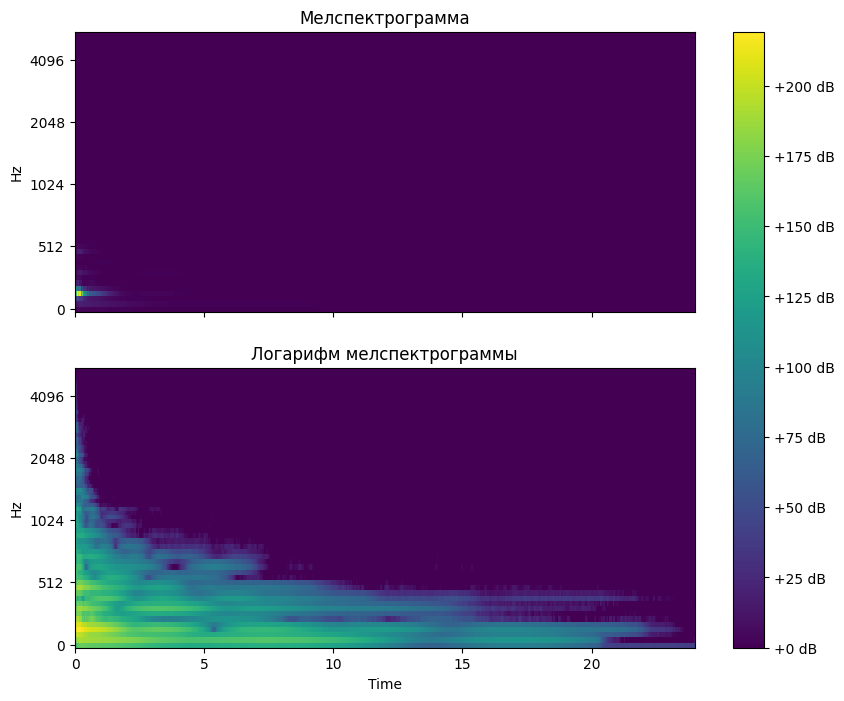

In [ ]:
wav_data, sr = librosa.load(os.path.join(train_folder, filename), sr=sample_rate)

mel_spec = librosa.feature.melspectrogram(
    y=wav_data,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels,
    fmax=sample_rate // 2
)

fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
cmap = "viridis"

img1 = librosa.display.specshow(
    mel_spec,
    sr=sr,
    fmax=sr // 2,
    ax=ax_top,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax_top.set(title='Мелспектрограмма')
ax_top.label_outer()

D = librosa.power_to_db(mel_spec, ref=np.max)
img2 = librosa.display.specshow(
    D,
    sr=sr,
    fmax=sr // 2,
    ax=ax_bottom,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax_bottom.set(title='Логарифм мелспектрограммы')
ax_bottom.label_outer()

fig.colorbar(img1, ax=[ax_top, ax_bottom], format="%+2.f dB")
plt.show()

display(Audio(wav_data, rate=sr))

## Извлечение признаков

In [ ]:
class SetType(Enum):
    """Set type"""
    TRAIN = 1
    TEST  = 2
    DEV   = 3


def process_audio_file(args):
    file_info, path_to_files, sr, n_fft, hop_length, n_mels, set_type = args

    if set_type == SetType.TRAIN:
        file_name, label, label_to_id = file_info
    else:
        file_name = file_info

    try:
        wav_data, actual_sr = librosa.load(os.path.join(path_to_files, file_name), sr=sr)
        if len(wav_data) == 0:
            wav_data = np.zeros(sr if sr else actual_sr)

        mel_spec = F_librosa.melspectrogram(
            y=wav_data,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            fmax=actual_sr // 2
        )
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        if set_type == SetType.TRAIN:
            return {
                'fname': file_name,
                'feature': log_mel_spec,
                'label_id': label_to_id[label]
            }
        else:
            return {
                'fname': file_name,
                'feature': log_mel_spec,
            }
    except Exception as e:
        print(f"error processing {file_name}: {e}")
        return None


def extract_log_mel_feats(set_type: SetType, path_to_csv: str, path_to_files: str,
                                  out_path: str, labels_pickle: str, sr: Optional[int], n_fft: int,
                                  hop_length: int, n_mels: int, max_workers: int = 4):
    """
    Extract features from given files using multithreading and store them in binary format.

    :param set_type: set type
    :param path_to_csv: path to loaded csv
    :param path_to_files: path to loaded data
    :param out_path: path to store extracted features
    :param labels_pickle: path to store labels dictionary
    :param sr: input files sample rate
    :param n_fft: size of fft window
    :param hop_length: hop size
    :param n_mels: number of mel band
    :param max_workers: number of parallel workers

    :return:
    """
    if set_type not in [SetType.TRAIN, SetType.TEST]:
        raise Exception(f'Such set type not supported: {set_type}')

    feats = []

    if set_type == SetType.TRAIN:
        meta = pd.read_csv(path_to_csv, skiprows=1, names=['fname', 'label'])

        file_names = list(meta['fname'])
        n_files = len(file_names)
        labels = list(meta['label'])

        uniq_labels = np.sort(np.unique(labels))
        label_to_id = {label: i for i, label in enumerate(uniq_labels)}

        print('Total files:', n_files)
        print(f'Using {max_workers} workers for parallel processing')

        file_infos = [(fname, label, label_to_id) for fname, label in zip(file_names, labels)]
        args_list = [(info, path_to_files, sr, n_fft, hop_length, n_mels, set_type)
                    for info in file_infos]

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = [executor.submit(process_audio_file, args) for args in args_list]

            for future in tqdm(as_completed(futures), total=len(futures), desc="Extracting features"):
                result = future.result()
                if result is not None:
                    feats.append(result)

        pickle.dump(feats, open(out_path, 'wb'))
        pickle.dump(label_to_id, open(labels_pickle, 'wb'))
        return label_to_id

    else:
        file_names = os.listdir(path_to_files)
        n_files = len(file_names)
        print('Total files:', n_files)
        print(f'Using {max_workers} workers for parallel processing')

        args_list = [(fname, path_to_files, sr, n_fft, hop_length, n_mels, set_type)
                    for fname in file_names]

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = [executor.submit(process_audio_file, args) for args in args_list]

            for future in tqdm(as_completed(futures), total=len(futures), desc="Extracting features"):
                result = future.result()
                if result is not None:
                    feats.append(result)

        pickle.dump(feats, open(out_path, 'wb'))
        return

In [ ]:
sample_rate = 11025
n_fft = 1024
overlap = 4
hop_length = n_fft // overlap
n_mels = 64

In [ ]:
label_to_id = extract_log_mel_feats(
    SetType.TRAIN,
    train_csv,
    train_folder,
    train_pickle,
    labels_pickle,
    sample_rate,
    n_fft,
    hop_length,
    n_mels
)

id_to_label = [label for label, i in label_to_id.items()]

Total files: 5683
Using 4 workers for parallel processing


Extracting features: 100%|██████████| 5683/5683 [09:04<00:00, 10.43it/s]


## Алгоритм детектирования

### Подготовительный этап

In [ ]:
device = device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
cpu_count = os.cpu_count()

num_workers = cpu_count if device == "cpu" else 0
num_workers, cpu_count

(0, 2)

#### Добиваемся максимальной воспроизводимости
Согласно данному мануалу: https://pytorch.org/docs/stable/notes/randomness.html

In [ ]:
def set_random_state(random_state:int=0) -> NoReturn:
    """Initialize random generators.

    Parameters
    ==========
    random_state : int = 0
        Determines random number generation for centroid initialization.
        Use an int to make the randomness deterministic.
    """
    torch.manual_seed(random_state)
    random.seed(random_state)
    np.random.seed(random_state)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_state)
        torch.cuda.manual_seed(random_state)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
random_state = 42

In [ ]:
set_random_state(random_state)

In [ ]:
torch.use_deterministic_algorithms(True)

In [ ]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8
%env PYTHONHASHSEED=42

env: CUBLAS_WORKSPACE_CONFIG=:4096:8
env: PYTHONHASHSEED=42


### Обучение нейронной сети

#### Загрузка ранее извлеченных признаков и подготовка данных для обучения

In [ ]:
train_data = pickle.load(open(train_pickle, "rb"))

label_to_id = pickle.load(open(labels_pickle, "rb"))
id_to_label = [label for label, i in label_to_id.items()]

In [ ]:
def prepare_shape(feature):
    tmp = feature
    N = 64
    while tmp.shape[1] < N:
        tmp = np.hstack((tmp, tmp))
    tmp = tmp[np.newaxis, :, :N]
    return tmp

In [ ]:
validation_set_size = 800

x_val = []
y_val = []

x_tr = []
y_tr = []

for i, row in enumerate(train_data):
    feature = prepare_shape(row['feature'])
    if i < validation_set_size:
        x_val.append(feature)
        y_val.append(row['label_id'])
    else:
        x_tr.append(feature)
        y_tr.append(row['label_id'])

x_val = np.asarray(x_val)
x_tr = np.asarray(x_tr)

y_val = np.asarray(y_val)
y_tr = np.asarray(y_tr)

print(f"""
Train set:
    x.shape: {x_tr.shape}
    y.shape: {y_tr.shape}

Validation set:
    x.shape: {x_val.shape}
    y.shape: {y_val.shape}
""")


Train set:
    x.shape: (4883, 1, 64, 64)
    y.shape: (4883,)

Validation set:
    x.shape: (800, 1, 64, 64)
    y.shape: (800,)



In [ ]:
class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None, device="cpu"):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if self.y is not None:
            return \
                torch.tensor(self.x[idx], device=device),\
                torch.tensor(self.y[idx], device=device)

        return torch.tensor(self.x[idx], device=device)

In [ ]:
train_dset = EventDetectionDataset(x_tr, y_tr, device=device)
val_dset = EventDetectionDataset(x_val, y_val, device=device)

In [ ]:
set_random_state(random_state)

sample_x, sample_y = random.choice(val_dset)

sample_y.item(), id_to_label[sample_y]

(10, np.str_('Cough'))

In [ ]:
sample_rate = 11025

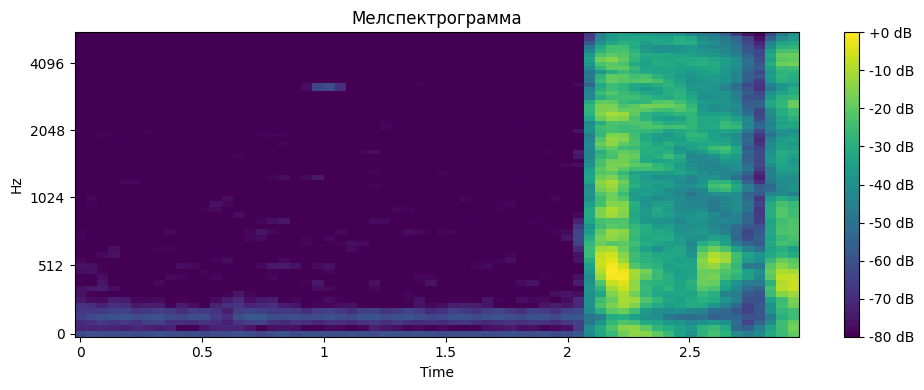

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
cmap = "viridis"

img = librosa.display.specshow(
    sample_x[0].numpy(force=True),
    sr=sample_rate,
    fmax=sample_rate // 2,
    ax=ax,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax.set(title='Мелспектрограмма')
ax.label_outer()

fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.tight_layout()
plt.show()

In [ ]:
train_loader = DataLoader(train_dset, batch_size=41, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dset, batch_size=41, shuffle=False, num_workers=num_workers)

In [ ]:
torch.use_deterministic_algorithms(False)
n_epoch = 200
set_random_state(random_state)

In [ ]:
class FinalNetwork(nn.Module):
    def __init__(self, num_classes=41, dropout_rate=0.4):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(dropout_rate),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(dropout_rate),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(dropout_rate),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Dropout2d(dropout_rate),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
network = FinalNetwork(num_classes=41).to(device)

print(f"Model device: {next(network.parameters()).device}")

Model device: cuda:0


In [ ]:
class WarmupAdamW(optim.AdamW):
    def __init__(self, params, lr=1e-3, warm_stage=5, **extra):
        super().__init__(params, lr=0.0, **extra)

        self._warm_steps = warm_stage
        self._target_lr = lr
        self._epoch_counter = 0

    def step(self, epoch=None):
        if epoch is not None:
            self._epoch_counter = epoch

        if self._epoch_counter < self._warm_steps:
            coef = (self._epoch_counter + 1) / self._warm_steps
            lr_value = self._target_lr * coef
        else:
            lr_value = self._target_lr

        for group in self.param_groups:
            group["lr"] = lr_value

        super().step()

In [ ]:
optimizer = WarmupAdamW(
    params=network.parameters(),
    lr=1e-3,
    warm_stage=5,
    weight_decay=1e-3,
    betas=(0.9, 0.999)
)

In [ ]:
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=10,
    min_lr=1e-6
)

In [ ]:
class SmoothedCELoss(nn.Module):
    def __init__(self, eps=0.1, mode="mean"):
        super().__init__()
        self.eps = eps
        self.mode = mode

    def forward(self, logits, targets):
        lsm = F_torch.log_softmax(logits, dim=1)
        ce_part = -lsm.gather(1, targets.unsqueeze(1)).squeeze(1)
        smooth_part = -lsm.mean(dim=1)
        total = (1 - self.eps) * ce_part + self.eps * smooth_part

        if self.mode == "mean":
            return total.mean()
        if self.mode == "sum":
            return total.sum()
        return total

In [ ]:
criterion = SmoothedCELoss(eps=0.1)

In [ ]:
training_log = {
    "loss_train": [],
    "loss_val": [],
    "f1_train": [],
    "f1_val": []
}

best_f1 = 0.0
best_state = None
no_progress = 0
early_stop_limit = 25

In [ ]:
print("Обучение модели началось")
for epoch_id in range(n_epoch):
    print(f"Эпоха: {epoch_id + 1}")

    optimizer.step(epoch_id)

    epoch_loss = 0
    preds_train = []
    labels_train = []

    network.train()
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = network(x_batch)
        loss_val = criterion(outputs, y_batch)
        loss_val.backward()

        torch.nn.utils.clip_grad_norm_(network.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss_val.item()
        preds_train.append(outputs.argmax(1).cpu())
        labels_train.append(y_batch.cpu())

    preds_train = torch.cat(preds_train).numpy()
    labels_train = torch.cat(labels_train).numpy()
    f1_train_value = f1_score(labels_train, preds_train, average="weighted")

    training_log["loss_train"].append(epoch_loss / len(train_loader))
    training_log["f1_train"].append(f1_train_value)

    print(f"Loss (train): {training_log['loss_train'][-1]:.4f}")
    print(f"F1 (train):   {f1_train_value:.4f}")

    network.eval()
    val_loss_accum = 0
    preds_val = []
    labels_val = []

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            out = network(x_batch)
            loss_val = criterion(out, y_batch)
            val_loss_accum += loss_val.item()

            preds_val.append(out.argmax(1).cpu())
            labels_val.append(y_batch.cpu())

    preds_val = torch.cat(preds_val).numpy()
    labels_val = torch.cat(labels_val).numpy()
    f1_val_value = f1_score(labels_val, preds_val, average="weighted")

    training_log["loss_val"].append(val_loss_accum / len(val_loader))
    training_log["f1_val"].append(f1_val_value)

    print(f"Loss (val): {training_log['loss_val'][-1]:.4f}")
    print(f"F1 (val):   {f1_val_value:.4f}")

    scheduler.step(f1_val_value)

    if f1_val_value > best_f1:
        best_f1 = f1_val_value
        best_state = network.state_dict().copy()
        no_progress = 0
        print(f"Обновлён лучший результат: {best_f1:.4f}")
    else:
        no_progress += 1
        print(f"Нет улучшений: {no_progress}")

        if no_progress >= early_stop_limit:
            print(f"Остановка на эпохе {epoch_id + 1}")
            break

    lr_now = optimizer.param_groups[0]["lr"]
    print(f"Текущий lr: {lr_now:.6f}")
    print()

Обучение модели началось
Эпоха: 1
Loss (train): 3.7024
F1 (train):   0.0397
Loss (val): 3.5771
F1 (val):   0.0324
Обновлён лучший результат: 0.0324
Текущий lr: 0.000200

Эпоха: 2
Loss (train): 3.4962
F1 (train):   0.0597
Loss (val): 3.3109
F1 (val):   0.0570
Обновлён лучший результат: 0.0570
Текущий lr: 0.000400

Эпоха: 3
Loss (train): 3.3129
F1 (train):   0.0876
Loss (val): 3.0571
F1 (val):   0.1365
Обновлён лучший результат: 0.1365
Текущий lr: 0.000600

Эпоха: 4
Loss (train): 3.2069
F1 (train):   0.1077
Loss (val): 2.9458
F1 (val):   0.1734
Обновлён лучший результат: 0.1734
Текущий lr: 0.000800

Эпоха: 5
Loss (train): 3.0940
F1 (train):   0.1376
Loss (val): 2.9236
F1 (val):   0.1771
Обновлён лучший результат: 0.1771
Текущий lr: 0.001000

Эпоха: 6
Loss (train): 3.0333
F1 (train):   0.1686
Loss (val): 2.7644
F1 (val):   0.2422
Обновлён лучший результат: 0.2422
Текущий lr: 0.001000

Эпоха: 7
Loss (train): 2.9459
F1 (train):   0.1955
Loss (val): 2.6463
F1 (val):   0.2648
Обновлён лучший 

In [ ]:
if best_state is not None:
    network.load_state_dict(best_state)
    print(f"Загружена модель с лучшим результатом F1 = {best_f1:.4f}")

Загружена модель с лучшим результатом F1 = 0.7021


In [ ]:
if best_f1 < 0.7:
    print("Формирование ансамбля из нескольких моделей")

    ensemble_outputs = []

    for model_idx in range(3):
        print(f"Модель ансамбля {model_idx + 1}")

        local_model = FinalNetwork(num_classes=41).to(device)
        local_model.load_state_dict(best_state)

        set_random_state(42 + model_idx)

        local_opt = optim.AdamW(
            local_model.parameters(),
            lr=1e-4,
            weight_decay=1e-4
        )

        local_model.train()
        for fine_epoch in range(10):
            for x_batch, y_batch in train_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                local_opt.zero_grad()
                out = local_model(x_batch)
                loss_loc = criterion(out, y_batch)
                loss_loc.backward()
                local_opt.step()

        local_model.eval()
        model_preds = []

        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                out = local_model(x_batch)
                model_preds.append(out.argmax(1).cpu())

        ensemble_outputs.append(torch.cat(model_preds).numpy())
        print(f"Модель ансамбля {model_idx + 1} готова")

    combined = []
    for i in range(len(ensemble_outputs[0])):
        sample_votes = [preds[i] for preds in ensemble_outputs]
        combined.append(max(set(sample_votes), key=sample_votes.count))

    combined = np.array(combined)
    final_f1 = f1_score(labels_val, combined, average="weighted")

    print(f"F1 ансамбля: {final_f1:.4f}")

    if final_f1 > best_f1:
        best_f1 = final_f1
        print(f"Результат улучшен!!!: {best_f1:.4f}")

In [ ]:
network.eval()

pred_labels = []
true_labels_list = []
prob_matrix = []

with torch.no_grad():
    for batch_inputs, batch_targets in val_loader:
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)

        logits = network(batch_inputs)
        prob_vec = F_torch.softmax(logits, dim=1)
        batch_preds = logits.argmax(dim=1)

        pred_labels.append(batch_preds.cpu())
        true_labels_list.append(batch_targets.cpu())
        prob_matrix.append(prob_vec.cpu())

pred_labels = torch.cat(pred_labels).numpy()
true_labels_list = torch.cat(true_labels_list).numpy()
prob_matrix = torch.cat(prob_matrix, dim=0).numpy()

In [ ]:
print("\nОтчет по классам:")
print(classification_report(true_labels_list, pred_labels))


Отчет по классам:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83        30
           1       0.76      0.79      0.77        28
           2       0.67      0.75      0.71        24
           3       0.85      0.88      0.87        26
           4       0.56      0.56      0.56         9
           5       0.27      0.57      0.36         7
           6       0.76      0.76      0.76        21
           7       0.60      0.30      0.40        10
           8       1.00      0.82      0.90        39
           9       0.33      0.31      0.32        13
          10       0.52      0.79      0.63        28
          11       0.88      0.88      0.88        16
          12       0.90      0.96      0.93        27
          13       0.29      0.45      0.36        11
          14       0.78      0.78      0.78         9
          15       0.68      0.77      0.72        22
          16       0.86      0.86      0.86         7
        

In [ ]:
conf_vals = np.max(prob_matrix, axis=1)
correct_mask = (pred_labels == true_labels_list)

print("\nПоказатели модели:")
print(f"Среднее значение: {conf_vals.mean():.4f}")
print(f"Для корректных предсказаний: {conf_vals[correct_mask].mean():.4f}")
print(f"Для ошибок модели: {conf_vals[~correct_mask].mean():.4f}")


Показатели модели:
Среднее значение: 0.7273
Для корректных предсказаний: 0.8451
Для ошибок модели: 0.4770


In [ ]:
f1_by_class = f1_score(true_labels_list, pred_labels, average=None)
low_rank_classes = np.argsort(f1_by_class)[:10]

print("\nКлассы с минимальными значениями F1:")
for cls_id in low_rank_classes:
    mask = (true_labels_list == cls_id)
    if np.sum(mask) > 0:
        acc_cls = np.mean(pred_labels[mask] == true_labels_list[mask])
        conf_cls = conf_vals[mask].mean()
        count_cls = np.sum(mask)

        print(f"Класс {cls_id}: "
              f"F1={f1_by_class[cls_id]:.4f}, "
              f"Точность={acc_cls:.4f}, "
              f"Уверенность={conf_cls:.4f}, "
              f"Количество={count_cls}")


Классы с минимальными значениями F1:
Класс 24: F1=0.1818, Точность=0.1538, Уверенность=0.4737, Количество=13
Класс 31: F1=0.2222, Точность=0.2000, Уверенность=0.5686, Количество=5
Класс 9: F1=0.3200, Точность=0.3077, Уверенность=0.3987, Количество=13
Класс 13: F1=0.3571, Точность=0.4545, Уверенность=0.4798, Количество=11
Класс 5: F1=0.3636, Точность=0.5714, Уверенность=0.5589, Количество=7
Класс 7: F1=0.4000, Точность=0.3000, Уверенность=0.4801, Количество=10
Класс 21: F1=0.4375, Точность=0.5000, Уверенность=0.7352, Количество=14
Класс 34: F1=0.4390, Точность=0.3333, Уверенность=0.5018, Количество=27
Класс 36: F1=0.4615, Точность=0.5000, Уверенность=0.5569, Количество=24
Класс 40: F1=0.4681, Точность=0.5000, Уверенность=0.5251, Количество=22


In [ ]:
plt.figure(figsize=(16, 5))

<Figure size 1600x500 with 0 Axes>

<Figure size 1600x500 with 0 Axes>

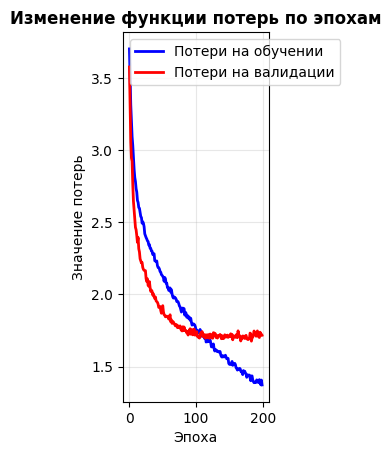

In [ ]:
plt.subplot(1, 3, 1)
plt.plot(training_log['loss_train'], label='Потери на обучении', color='blue', linewidth=2)
plt.plot(training_log['loss_val'], label='Потери на валидации', color='red', linewidth=2)
plt.title('Изменение функции потерь по эпохам', fontsize=12, fontweight='bold')
plt.xlabel('Эпоха')
plt.ylabel('Значение потерь')
plt.legend()
plt.grid(True, alpha=0.3)

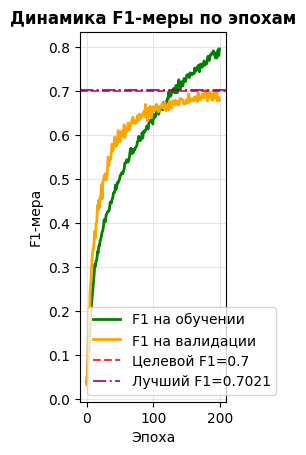

In [ ]:
plt.subplot(1, 3, 2)
plt.plot(training_log['f1_train'], label='F1 на обучении', color='green', linewidth=2)
plt.plot(training_log['f1_val'], label='F1 на валидации', color='orange', linewidth=2)
plt.axhline(y=0.7, color='red', linestyle='--', label='Целевой F1=0.7', alpha=0.8)
plt.axhline(y=best_f1, color='purple', linestyle='-.',
            label=f'Лучший F1={best_f1:.4f}', alpha=0.8)
plt.title('Динамика F1-меры по эпохам', fontsize=12, fontweight='bold')
plt.xlabel('Эпоха')
plt.ylabel('F1-мера')
plt.legend()
plt.grid(True, alpha=0.3)

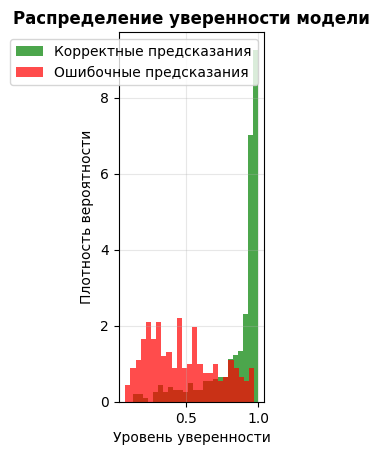

In [ ]:
plt.subplot(1, 3, 3)
plt.hist(conf_vals[correct_mask], bins=25, alpha=0.7,
         label='Корректные предсказания', color='green', density=True)
plt.hist(conf_vals[~correct_mask], bins=25, alpha=0.7,
         label='Ошибочные предсказания', color='red', density=True)
plt.title('Распределение уверенности модели', fontsize=12, fontweight='bold')
plt.xlabel('Уровень уверенности')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid(True, alpha=0.3)

In [ ]:
print(f"\nФинальный F1 модели: {best_f1:.4f}")


Финальный F1 модели: 0.7021


#Предсказание на тестовом наборе и сохранение csv файла

In [ ]:
print("Создание файла submission")
print("-"*50)

test_pickle_path = path.join(base_folder, "test.pickle")

print("Извлечение признаков для тестовых данных...")
extract_log_mel_feats(
    SetType.TEST,
    test_labels,
    test_folder,
    test_pickle_path,
    labels_pickle,
    sample_rate,
    n_fft,
    hop_length,
    n_mels
)

test_data_list = pickle.load(open(test_pickle_path, "rb"))
print(f"Загружено {len(test_data_list)} тестовых объектов")

x_test_features = []
test_filenames = []

for item in test_data_list:
    feat = prepare_shape(item['feature'])
    x_test_features.append(feat)
    test_filenames.append(item['fname'])

x_test_features = np.asarray(x_test_features)
print(f"Тестовый набор: x.shape = {x_test_features.shape}")

Создание файла submission
--------------------------------------------------
Извлечение признаков для тестовых данных...
Total files: 3790
Using 4 workers for parallel processing


Extracting features: 100%|██████████| 3790/3790 [06:29<00:00,  9.72it/s]


Загружено 3790 тестовых объектов
Тестовый набор: x.shape = (3790, 1, 64, 64)


In [ ]:
test_dataset = EventDetectionDataset(x_test_features, device=device)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)

network.eval()
test_predictions = []

with torch.no_grad():
    for batch_data in tqdm(test_loader):
        batch_data = batch_data.to(device)
        output_logits = network(batch_data)
        batch_preds = output_logits.argmax(dim=1)
        test_predictions.extend(batch_preds.cpu().numpy())

predicted_labels = [id_to_label[p] for p in test_predictions]

submission_template = pd.read_csv(path.join(base_folder, test_labels))
submission_map = dict(zip(test_filenames, predicted_labels))
submission_template['label'] = submission_template['fname'].map(submission_map)

if submission_template['label'].isnull().any():
    most_common_label = max(set(predicted_labels), key=predicted_labels.count)
    submission_template['label'] = submission_template['label'].fillna(most_common_label)

100%|██████████| 119/119 [00:00<00:00, 242.22it/s]


In [ ]:
submission_file_path = path.join(base_folder, "submission_final.csv")
submission_template.to_csv(submission_file_path, index=False)

print(f"Submission файл сохранен: {submission_file_path}")
print(f"Количество строк: {len(submission_template)}")
print("\nПервые 5 строк файла:")
print(submission_template.head())

print("\nРаспределение предсказанных меток:")
print(submission_template['label'].value_counts())

Submission файл сохранен: /content/drive/MyDrive/event_detection_kaggle/submission_final.csv
Количество строк: 3790

Первые 5 строк файла:
                      fname            label
0  973a8b381d1875ebe120.wav            Knock
1  052e1cbeb4391d6af234.wav  Acoustic_guitar
2  16eb98d96319450e0949.wav            Knock
3  ff13c136c04f274229a5.wav            Knock
4  b458211304f7a14b29b2.wav            Cough

Распределение предсказанных меток:
label
Applause                 151
Writing                  146
Cough                    145
Flute                    145
Tearing                  141
Oboe                     138
Hi-hat                   127
Bass_drum                125
Acoustic_guitar          124
Cello                    122
Double_bass              121
Fireworks                119
Laughter                 119
Clarinet                 118
Violin_or_fiddle         115
Saxophone                115
Shatter                  112
Knock                    110
Snare_drum               10

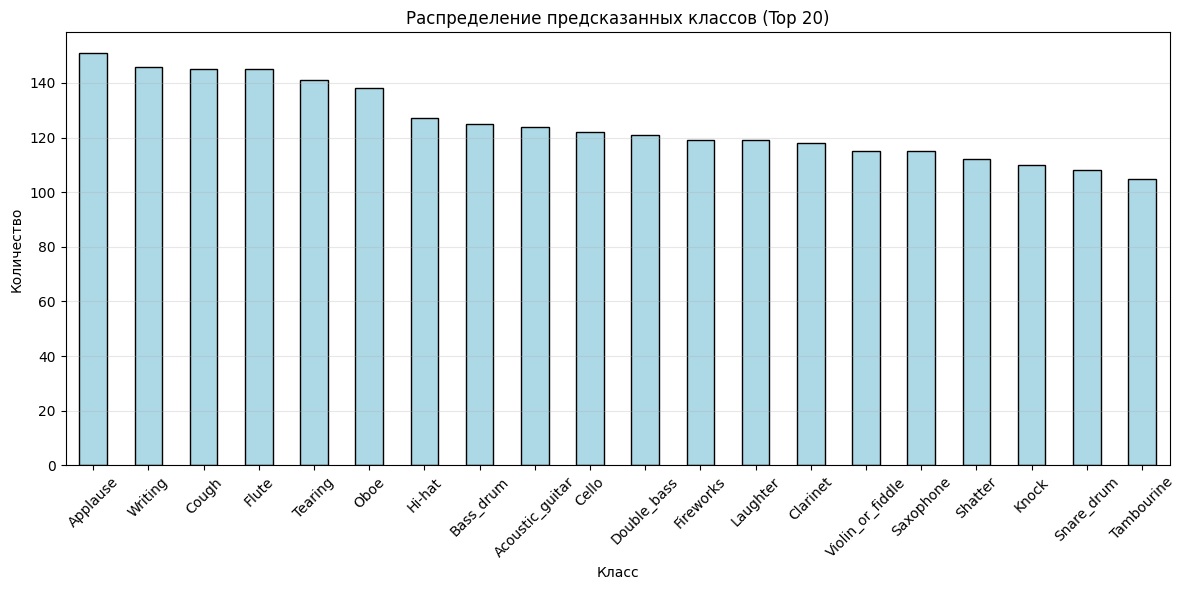

In [ ]:
plt.figure(figsize=(12, 6))
submission_template['label'].value_counts().head(20).plot(
    kind='bar', color='lightblue', edgecolor='black'
)
plt.title('Распределение предсказанных классов (Top 20)')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
network.eval()
val_preds = []
val_targets = []

with torch.no_grad():
    for batch_data, batch_labels in val_loader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        outputs = network(batch_data)
        batch_preds = outputs.argmax(dim=1)
        val_preds.extend(batch_preds.cpu().numpy())
        val_targets.extend(batch_labels.cpu().numpy())

val_acc = accuracy_score(val_targets, val_preds)
val_f1 = f1_score(val_targets, val_preds, average='weighted')

print(f"Точность на валидации: {val_acc:.4f}")
print(f"F1-score на валидации: {val_f1:.4f}")
print("\nОтчет по классификации:")
print(classification_report(val_targets, val_preds, target_names=id_to_label))

Точность на валидации: 0.6800
F1-score на валидации: 0.6789

Отчет по классификации:
                       precision    recall  f1-score   support

      Acoustic_guitar       0.79      0.87      0.83        30
             Applause       0.76      0.79      0.77        28
                 Bark       0.67      0.75      0.71        24
            Bass_drum       0.85      0.88      0.87        26
Burping_or_eructation       0.56      0.56      0.56         9
                  Bus       0.27      0.57      0.36         7
                Cello       0.76      0.76      0.76        21
                Chime       0.60      0.30      0.40        10
             Clarinet       1.00      0.82      0.90        39
    Computer_keyboard       0.33      0.31      0.32        13
                Cough       0.52      0.79      0.63        28
              Cowbell       0.88      0.88      0.88        16
          Double_bass       0.90      0.96      0.93        27
 Drawer_open_or_close       0.29

In [ ]:
if best_f1 >= 0.65 and 'ensemble_model_predictions' in locals() and len(ensemble_model_predictions) > 0:
    ensemble_test_preds = []

    for idx in range(len(ensemble_model_predictions)):
        ensemble_net = FinalNetwork(num_classes=41).to(device)
        ensemble_net.load_state_dict(saved_model_weights)
        ensemble_net.eval()

        preds_batch = []
        with torch.no_grad():
            for batch_data in test_loader:
                batch_data = batch_data.to(device)
                logits = ensemble_net(batch_data)
                preds_batch.extend(logits.argmax(dim=1).cpu().numpy())

        ensemble_test_preds.append(preds_batch)

    final_ensemble_preds = []
    for i in range(len(test_predictions)):
        votes = [test_predictions[i]] + [preds[i] for preds in ensemble_test_preds]
        final_ensemble_preds.append(max(set(votes), key=votes.count))

    ensemble_labels = [id_to_label[p] for p in final_ensemble_preds]
    ensemble_submission = submission_template.copy()
    ensemble_map = dict(zip(test_filenames, ensemble_labels))
    ensemble_submission['label'] = ensemble_submission['fname'].map(ensemble_map)

    if ensemble_submission['label'].isnull().any():
        most_common_label_ens = max(set(ensemble_labels), key=ensemble_labels.count)
        ensemble_submission['label'] = ensemble_submission['label'].fillna(most_common_label_ens)

    ensemble_file_path = path.join(base_folder, "submission_ensemble.csv")
    ensemble_submission.to_csv(ensemble_file_path, index=False)
    print(f"Ансамблевый submission сохранен: {ensemble_file_path}")

In [ ]:
print("Итог:")
print(f"- Лучший F1 на валидации: {best_f1:.4f}")
print(f"- Точность на валидации: {val_acc:.4f}")
print(f"- F1-score на валидации: {val_f1:.4f}")
print(f"- Количество тестовых файлов: {len(test_data_list)}")
print(f"- Количество классов: {len(id_to_label)}")
print(f"Submission файл: {submission_file_path}")
if 'ensemble_file_path' in locals():
    print(f"Ансамблевый submission файл: {ensemble_file_path}")

Итог:
- Лучший F1 на валидации: 0.7021
- Точность на валидации: 0.6800
- F1-score на валидации: 0.6789
- Количество тестовых файлов: 3790
- Количество классов: 41
Submission файл: /content/drive/MyDrive/event_detection_kaggle/submission_final.csv
